# **DATA FEATURE ENGINEERING NOTEBOOK**

## Objectives

*   Engineer features for Classification and Regression

## Inputs

* outputs/datasets/cleaned/TrainSetClassificationCleaned.csv
* outputs/datasets/cleaned/TestSetClassificationCleaned.csv
* outputs/datasets/cleaned/TrainSetRegressionCleaned.csv
* outputs/datasets/cleaned/TestSetRegressionCleaned.csv

## Outputs

* generate a list with variables to engineer

## Conclusions

* Feature Engineering Transformers
  * Ordinal categorical encoding: none
  * Smart Correlation Selection: ['Premis Desc', 'Damage']


---

# Change working directory

* access the current directory
* make the parent of the current directory the new current directory

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspace/PP5_My_project'

---

# Load Data

Train set

In [2]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetClassificationCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,...,LOCATION,Cross Street,LAT,LON,Day of Week,Amount,Damage,Year_OCC,Month_OCC,Day_OCC
0,1000,15,8,626,53,21,0,15,101.0,164,...,5410,574,34.1921,-118.4052,2,0.0,0,2021,6,1
1,1910,1,1,440,85,33,1,6,102.0,156,...,2544,184,34.0537,-118.2455,7,950.0,1,2020,3,8
2,2320,3,15,230,2,26,1,15,101.0,164,...,6830,335,34.0158,-118.2828,7,0.0,0,2022,3,6


Test set

In [3]:
test_set_path = 'outputs/datasets/cleaned/TestSetClassificationCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,...,LOCATION,Cross Street,LAT,LON,Day of Week,Amount,Damage,Year_OCC,Month_OCC,Day_OCC
0,2300,18,14,510,95,0,2,15,101.0,164,...,6654,184,33.9465,-118.2781,7,20000.0,1,2020,2,16
1,1900,5,4,510,95,0,2,15,101.0,164,...,78,574,33.7433,-118.2901,3,20000.0,1,2022,10,19
2,1820,1,1,210,70,27,0,14,104.0,42,...,975,574,34.0406,-118.2646,3,10000.0,1,2021,4,14


---

# Feature Engineering

## Custom function

function from the course feature engine

In [4]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Dealing with Feature Engineering

### Categorical Encoding

In [8]:
# Select all variables
variables_names = TestSet.columns.tolist()

variables_names

['TIME OCC',
 'AREA',
 'AREA NAME',
 'Crm Cd',
 'Crm Cd Desc',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON',
 'Day of Week',
 'Amount',
 'Damage',
 'Year_OCC',
 'Month_OCC',
 'Day_OCC']

In [9]:
df_engineering = TrainSet[variables_names].copy()
df_engineering.head(3)

,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,...,LOCATION,Cross Street,LAT,LON,Day of Week,Amount,Damage,Year_OCC,Month_OCC,Day_OCC
0,1000,15,8,626,53,21,0,15,101.0,164,...,5410,574,34.1921,-118.4052,2,0.0,0,2021,6,1
1,1910,1,1,440,85,33,1,6,102.0,156,...,2544,184,34.0537,-118.2455,7,950.0,1,2020,3,8
2,2320,3,15,230,2,26,1,15,101.0,164,...,6830,335,34.0158,-118.2828,7,0.0,0,2022,3,6


* Variable Analyzed: TIME OCC
* Applied transformation: [] 



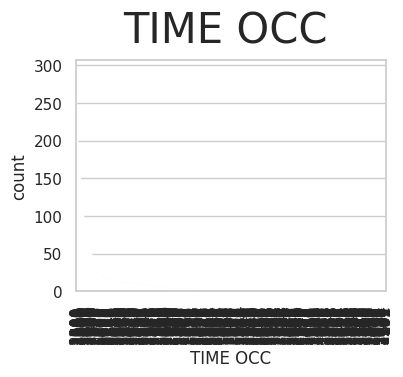





* Variable Analyzed: AREA
* Applied transformation: [] 



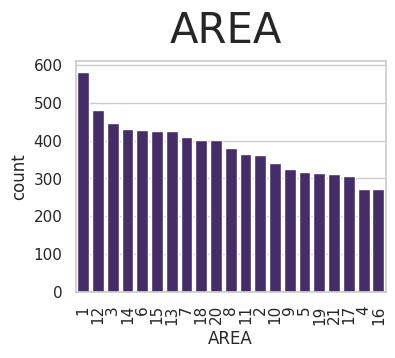





* Variable Analyzed: AREA NAME
* Applied transformation: [] 



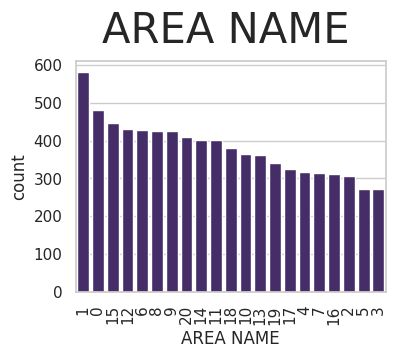





* Variable Analyzed: Crm Cd
* Applied transformation: [] 



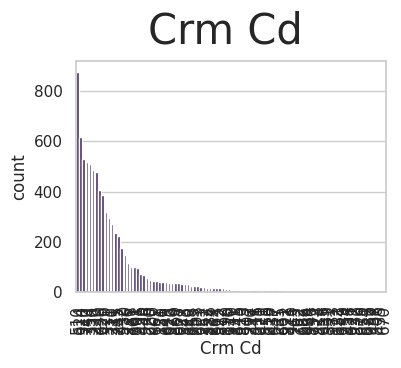





* Variable Analyzed: Crm Cd Desc
* Applied transformation: [] 



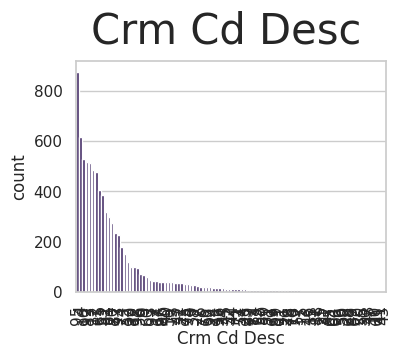





* Variable Analyzed: Vict Age
* Applied transformation: [] 



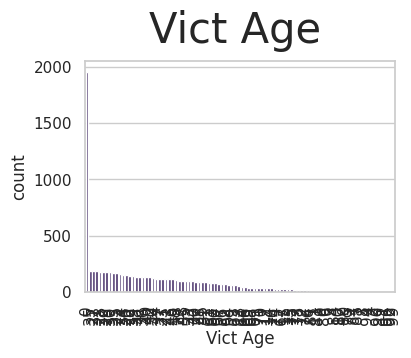





* Variable Analyzed: Vict Sex
* Applied transformation: [] 



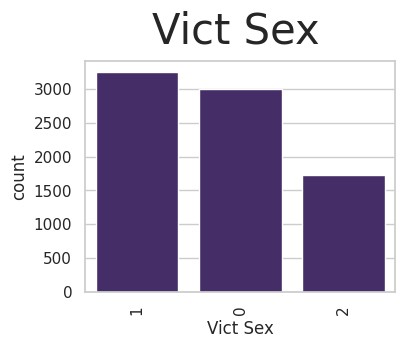





* Variable Analyzed: Vict Descent
* Applied transformation: [] 



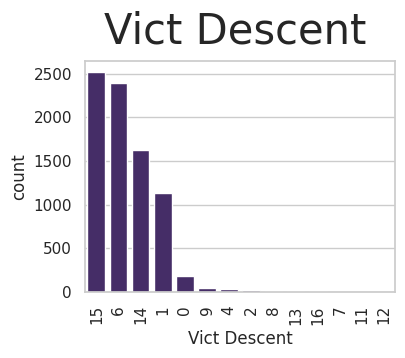





* Variable Analyzed: Premis Cd
* Applied transformation: [] 



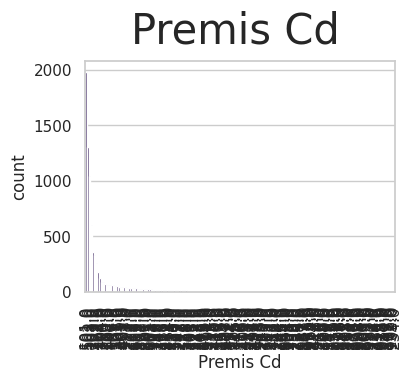





* Variable Analyzed: Premis Desc
* Applied transformation: [] 



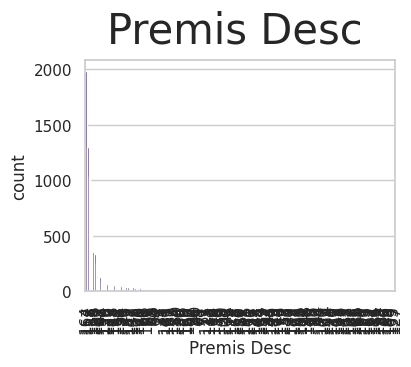





* Variable Analyzed: Weapon Used Cd
* Applied transformation: [] 



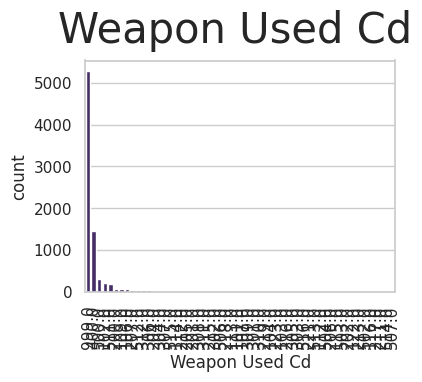





* Variable Analyzed: Weapon Desc
* Applied transformation: [] 



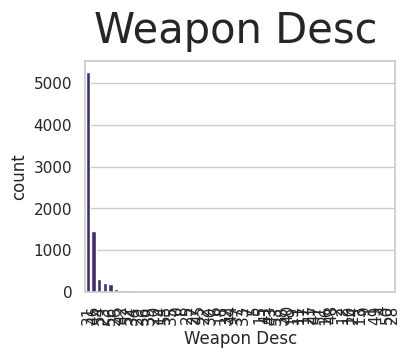





* Variable Analyzed: LOCATION
* Applied transformation: [] 



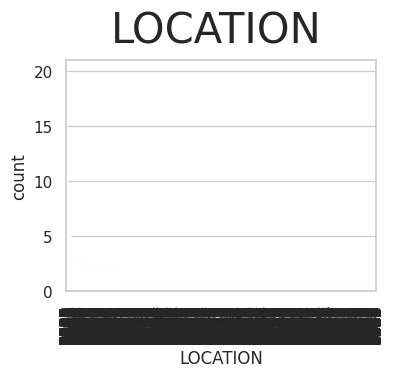





* Variable Analyzed: Cross Street
* Applied transformation: [] 



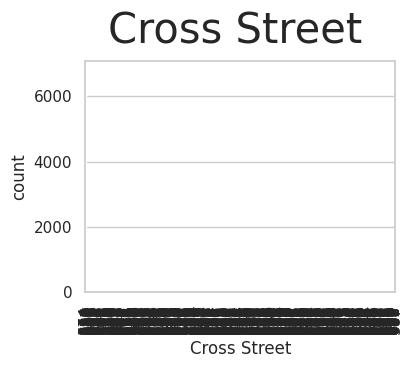





* Variable Analyzed: LAT
* Applied transformation: [] 



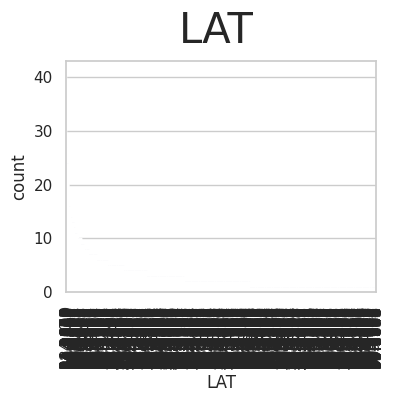





* Variable Analyzed: LON
* Applied transformation: [] 



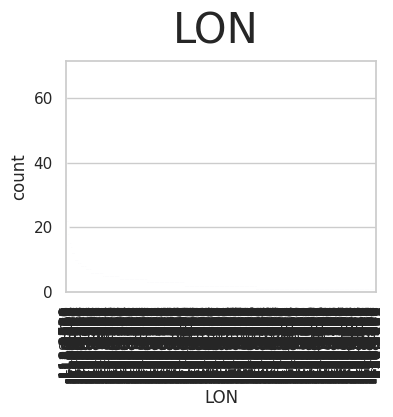





* Variable Analyzed: Day of Week
* Applied transformation: [] 



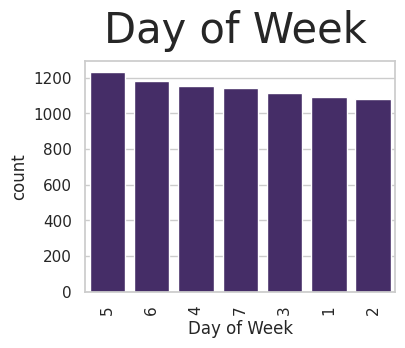





* Variable Analyzed: Amount
* Applied transformation: [] 



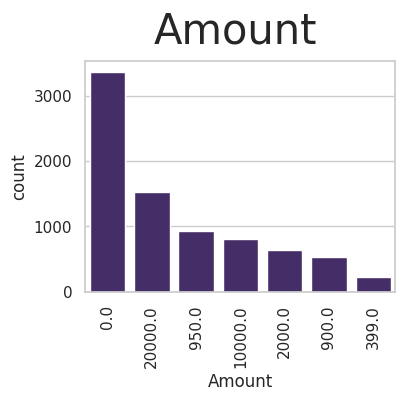





* Variable Analyzed: Damage
* Applied transformation: [] 



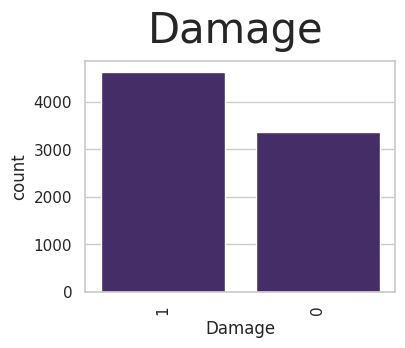





* Variable Analyzed: Year_OCC
* Applied transformation: [] 



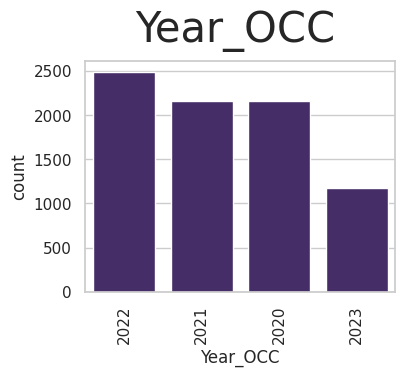





* Variable Analyzed: Month_OCC
* Applied transformation: [] 



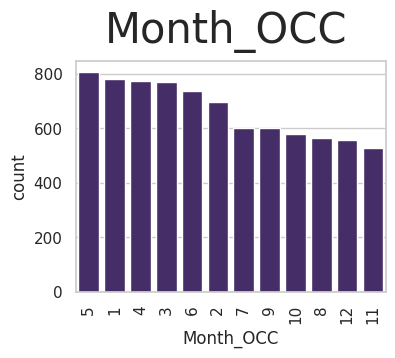





* Variable Analyzed: Day_OCC
* Applied transformation: [] 



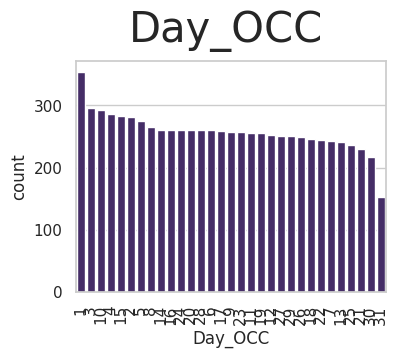

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

In [11]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_names)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

TypeError: Some of the variables are not categorical. Please cast them as categorical or object before using this transformer.

---

### Numerical Transformation

In [12]:
variables_engineering = ['Damage', 'Amount']
variables_engineering

['Damage', 'Amount']

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,Damage,Amount
0,0,0.0
1,1,950.0
2,0,0.0


* Variable Analyzed: Damage
* Applied transformation: ['Damage_power', 'Damage_yeo_johnson'] 



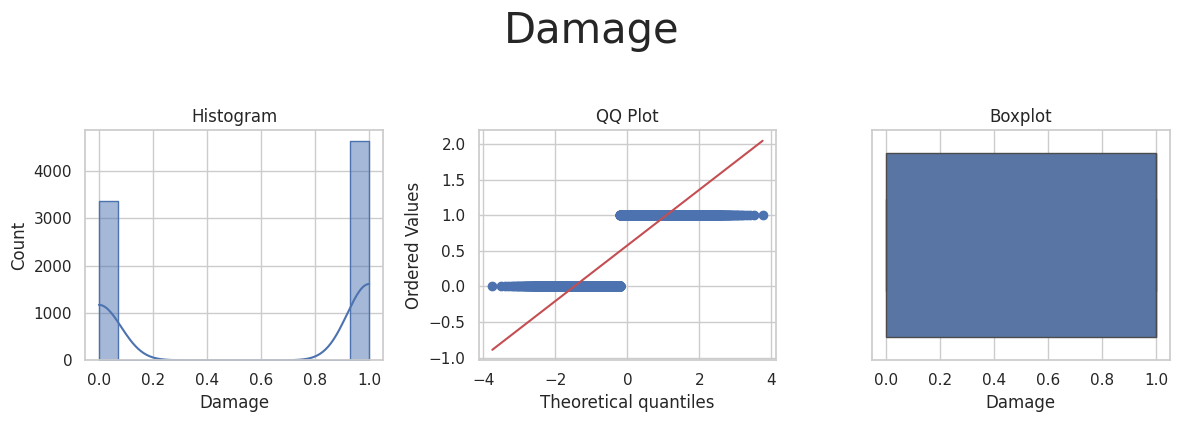

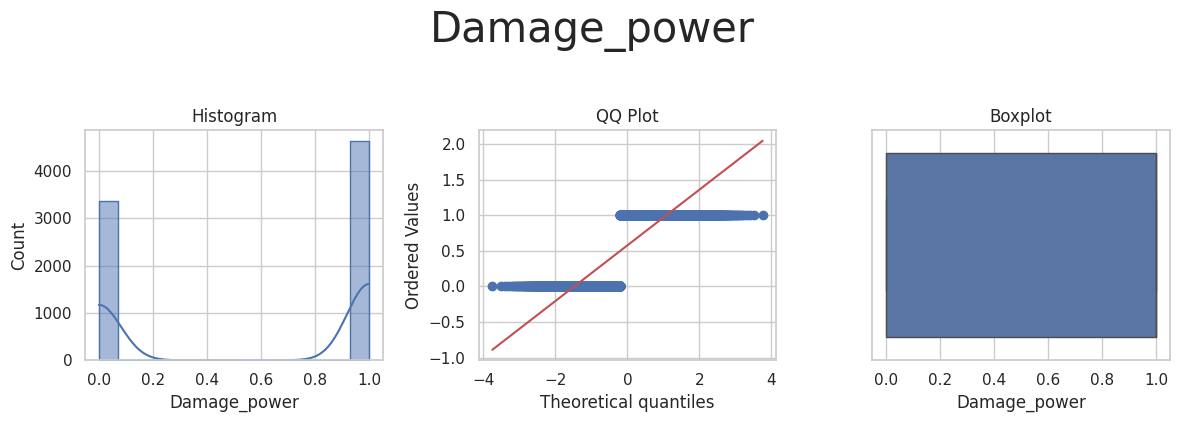

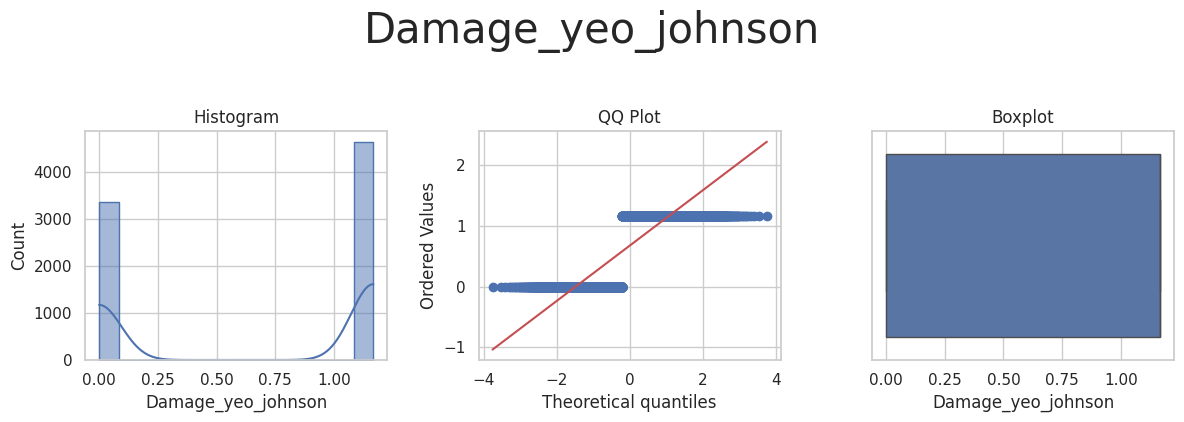



* Variable Analyzed: Amount
* Applied transformation: ['Amount_power', 'Amount_yeo_johnson'] 



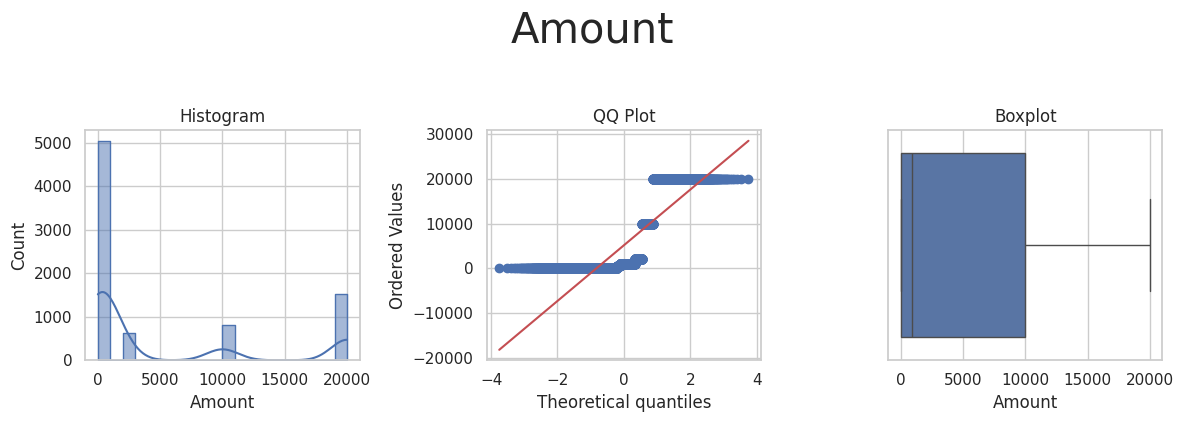

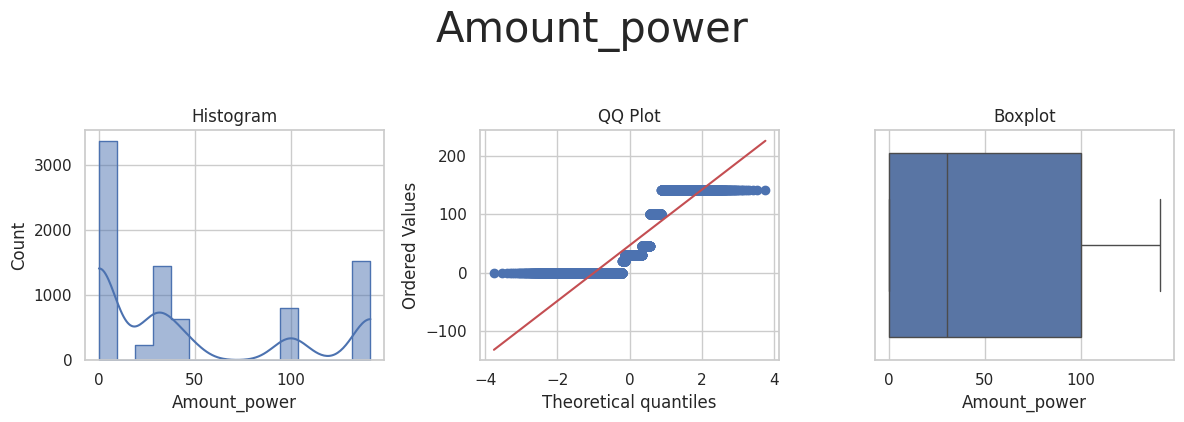

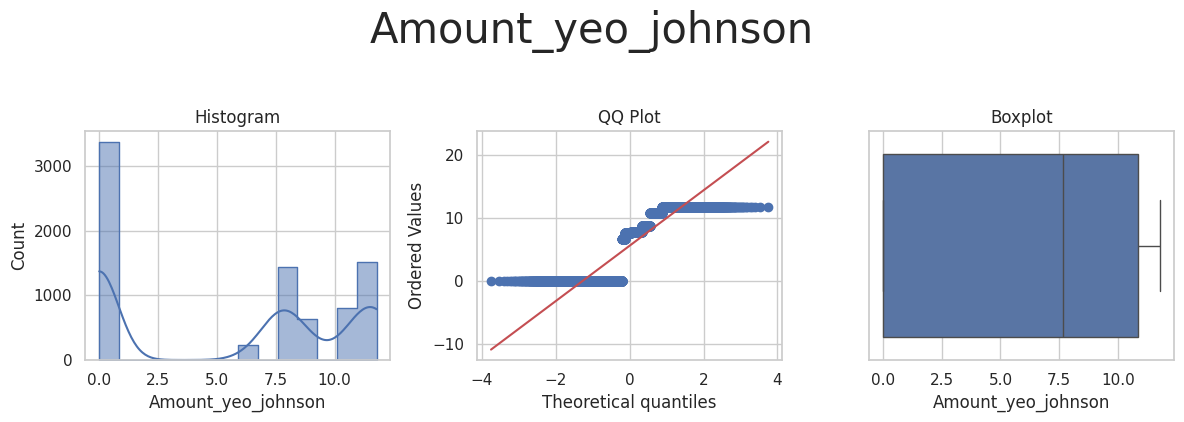

In [14]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

---

### SmartCorrelatedSelection Variables

In [15]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

,TIME OCC,AREA,AREA NAME,Crm Cd,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,...,LOCATION,Cross Street,LAT,LON,Day of Week,Amount,Damage,Year_OCC,Month_OCC,Day_OCC
0,1000,15,8,626,53,21,0,15,101.0,164,...,5410,574,34.1921,-118.4052,2,0.0,0,2021,6,1
1,1910,1,1,440,85,33,1,6,102.0,156,...,2544,184,34.0537,-118.2455,7,950.0,1,2020,3,8
2,2320,3,15,230,2,26,1,15,101.0,164,...,6830,335,34.0158,-118.2828,7,0.0,0,2022,3,6


In [16]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'Premis Cd', 'Premis Desc'}, {'Amount', 'Damage'}]

In [17]:
corr_sel.features_to_drop_

['Premis Desc', 'Damage']

---

# Conclusion and next step

Feature Engineering Transformers
  * Numerical Transformation: `['Damage_power', 'Damage_yeo_johnson'] and ['Amount_power', 'Amount_yeo_johnson']`
  * Smart Correlation Selection: `['OnlineSecurity', 'DeviceProtection', 'TechSupport']`